In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
import importlib
from tight_binding_redweasel import *
from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import fermi_surface as fs

### Coefficientfunctions
Define a couple functions for the coefficients for the tests.

In [2]:
def f_i_linear(k, i):
    assert i >= 0
    if i == 0:
        return np.ones_like(k[..., 0])
    return k[..., i-1]

def df_i_linear(k, i):
    assert i >= 0
    d = np.zeros_like(k)
    if i == 0:
        return d
    d[..., i-1] = 1.0
    return d

def ddf_i_linear(k, i):
    return np.zeros(np.shape(k) + (np.shape(k)[-1],))

def f_i_exp(k, i):
    assert i >= 0
    if i == 0:
        return np.ones_like(k[..., 0])
    if i % 2 == 1:
        return np.cos(k[..., (i-1)//2])
    else:
        return np.sin(k[..., (i-1)//2])

def df_i_exp(k, i):
    assert i >= 0
    d = np.zeros_like(k)
    if i == 0:
        return d
    d[..., (i-1)//2] = 1.0
    if i % 2 == 1:
        return -np.sin(k[..., (i-1)//2])[:,None] * d
    else:
        return np.cos(k[..., (i-1)//2])[:,None] * d

def ddf_i_exp(k, i):
    assert i >= 0
    d = np.zeros(np.shape(k) + (np.shape(k)[-1],))
    if i == 0:
        return d
    d[..., (i-1)//2, (i-1)//2] = 1.0
    if i % 2 == 1:
        return -np.cos(k[..., (i-1)//2])[:,None,None] * d
    else:
        return -np.sin(k[..., (i-1)//2])[:,None,None] * d

# Tests

[[[-0.294+0.j     0.   -0.j   ]
  [ 0.   +0.j     1.59 +0.j   ]]

 [[ 0.276+0.j     1.619+0.j   ]
  [ 1.619-0.j    -0.713+0.j   ]]

 [[-0.551+0.j     0.463-0.726j]
  [ 0.463+0.726j -0.952+0.j   ]]]
final loss: 5.41e-08 (max band-error [0. 0.])
final loss: 5.4081767224442306e-08
[[[-0.294-0.j    -0.   -0.j   ]
  [ 0.   -0.j     1.59 -0.j   ]]

 [[ 0.276+0.j     1.619+0.j   ]
  [ 1.619-0.j    -0.713-0.j   ]]

 [[-0.551+0.j     0.463+0.726j]
  [ 0.463-0.726j -0.952-0.j   ]]]


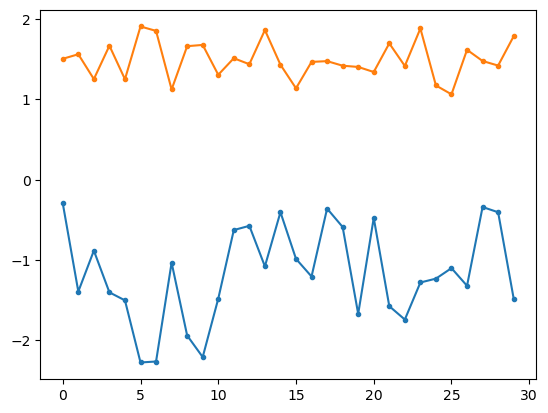

In [3]:
tb2 = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(2),
                         random_hermitian(2),
                         random_hermitian(2)])

tb2_ref = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(2),
                         random_hermitian(2),
                         random_hermitian(2)])
tb2_ref.normalize()
print(tb2_ref.params)

#k_smpl = np.linspace(-2, 2, 20).reshape(-1, 1)
k_smpl = np.random.random((30, 2))

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1], 0, 1000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

In [4]:
# test gradients
tb2 = BandStructureModel(f_i_exp, df_i_exp,
                        [random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6)], ddf_i_exp)
tb2.normalize()

h = 1e-6
k_smpl = np.random.random((30, 3))
dx = np.reshape((h, 0, 0), (1, -1))
dy = np.reshape((0, h, 0), (1, -1))
dz = np.reshape((0, 0, h), (1, -1))

# test gradients
bands, grads = tb2.bands_grad(k_smpl)
bandsx = tb2.bands(k_smpl + dx)
bandsy = tb2.bands(k_smpl + dy)
bandsz = tb2.bands(k_smpl + dz)
# the following should be of order 10
print(np.linalg.norm(bands + (grads * dx.reshape(1,-1,1)).sum(1) - bandsx) / h**2)
print(np.linalg.norm(bands + (grads * dy.reshape(1,-1,1)).sum(1) - bandsy) / h**2)
print(np.linalg.norm(bands + (grads * dz.reshape(1,-1,1)).sum(1) - bandsz) / h**2)

# test hessians
k_smpl = np.random.random((30, 3))
bands, grads, hess = tb2.bands_grad_hess(k_smpl)
#print(np.linalg.norm(hess, axis=(0, -1)))
bandsx, gradsx = tb2.bands_grad(k_smpl + dx)
bandsy, gradsy = tb2.bands_grad(k_smpl + dy)
bandsz, gradsz = tb2.bands_grad(k_smpl + dz)
# the following should be of order 10
print(np.linalg.norm(grads + hess[:,:,0]*h - gradsx, axis=(0,2)) / h**2)
print(np.linalg.norm(grads + hess[:,:,1]*h - gradsy, axis=(0,2)) / h**2)
print(np.linalg.norm(grads + hess[:,:,2]*h - gradsz, axis=(0,2)) / h**2)


9.420461171224277
11.895863408520013
15.428711727312049
[36.949 11.351 18.081]
[12.93  23.558 11.712]
[24.42  13.476 48.079]


[[[-1.235+0.j     0.   -0.j     0.   -0.j   ]
  [ 0.   +0.j     0.396+0.j    -0.   -0.j   ]
  [ 0.   +0.j    -0.   +0.j     1.466+0.j   ]]

 [[ 1.123-0.j     1.066-0.j    -0.856+0.656j]
  [ 1.066+0.j    -0.714+0.j     1.373-0.j   ]
  [-0.856-0.656j  1.373+0.j     0.045+0.j   ]]]
loss: 3.53e-07 (max band-error [0. 0. 0.])1 0.001])

final loss: 9.23e-12 (max band-error [0. 0. 0.])
final loss: 9.230143632284406e-12
[[[-1.235-0.j    -0.   -0.j    -0.   -0.j   ]
  [ 0.   +0.j     0.396+0.j    -0.   +0.j   ]
  [ 0.   +0.j     0.   -0.j     1.466+0.j   ]]

 [[ 1.123+0.j     0.936+0.j    -1.231-0.282j]
  [ 0.936-0.j    -0.714+0.j     1.31 +0.j   ]
  [-1.231+0.282j  1.31 -0.j     0.045-0.j   ]]]


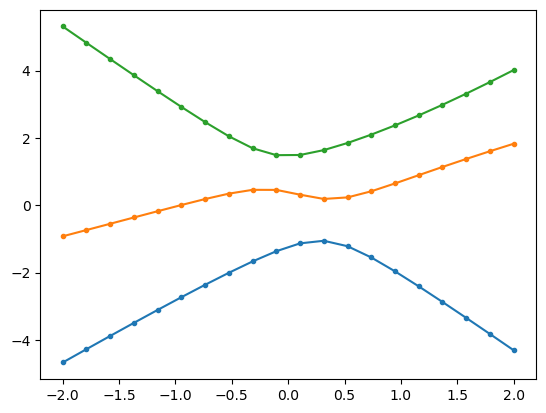

In [5]:
tb2 = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(3),
                         random_hermitian(3)])

tb2_ref = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(3),
                         random_hermitian(3)])
tb2_ref.normalize()
print(tb2_ref.params)

k_smpl = np.linspace(-2, 2, 20).reshape(-1, 1)

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1, 1], 0, 1000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

# Real Data

For real data, use a tight binding model with just $\cos$ terms. The Hamilton operator of this model has only s symmetry orbitals. These orbitals can be located at any high symmtry point. Together they can form the orbitals that have a different symmetry.

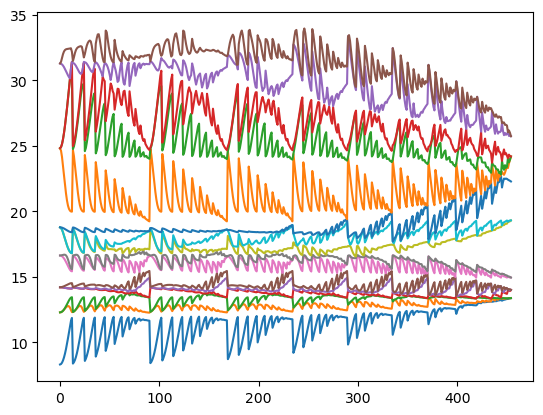

In [2]:
# read the data from Bandx.dat from Quantum Espresso
material = qe.QECrystal("nitinol_2_993", [], [], [], 0)
k_smpl, ref_weights, ref_bands, symmetries, fermi_energy = material.read_bands()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
plot_bands_generic(k_smpl, ref_bands, '-')

preparing pseudoinverse
maximal acceleration 2.0
loss: 6.30e+00 (max band-error [5.162 1.549 1.368 0.491 0.901 1.114 1.35  1.738 1.971 2.112 3.078 5.106
loss: 3.44e+00 (max band-error [4.562 1.175 0.737 0.401 0.589 0.693 0.883 1.481 1.142 1.399 2.305 2.989
loss: 1.72e+00 (max band-error [3.752 0.742 0.412 0.308 0.297 0.52  0.656 1.129 0.86  0.581 1.382 2.856
loss: 1.91e+00 (max band-error [2.948 0.425 0.503 0.323 0.305 0.463 0.636 0.782 0.88  0.7   0.818 2.906
loss: 1.63e+00 (max band-error [2.249 0.319 0.447 0.379 0.297 0.491 0.504 0.553 0.595 1.319 1.042 1.983
loss: 1.23e+00 (max band-error [1.681 0.348 0.36  0.314 0.318 0.419 0.509 0.402 0.425 1.528 0.931 1.444
loss: 1.11e+00 (max band-error [1.262 0.358 0.34  0.228 0.358 0.394 0.469 0.34  0.392 1.393 0.676 1.621
loss: 1.06e+00 (max band-error [0.968 0.331 0.343 0.237 0.349 0.371 0.461 0.297 0.352 1.117 0.769 1.894
loss: 9.78e-01 (max band-error [0.76  0.358 0.29  0.273 0.311 0.332 0.417 0.261 0.28  0.834 0.911 1.907
loss: 9.22e-01 

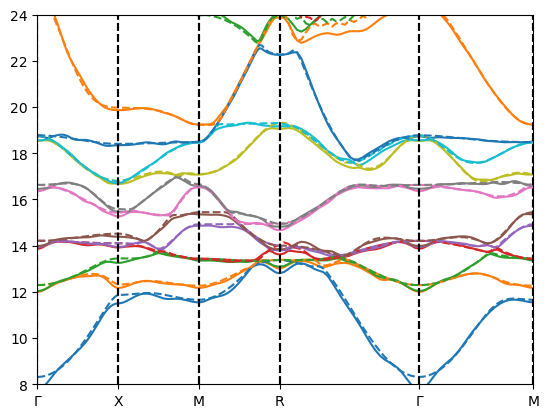

In [15]:
# read the data from Bandx.dat from Quantum Espresso
material = qe.QECrystal("nitinol_2_993", [], [], [], 0)
k_smpl, ref_weights, ref_bands, symmetries, fermi_energy = material.read_bands()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]

# now start my algorithm to find good matrices
add_bands = 0
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[6] = 1
weights[7] = 1
weights[-1] = 0.5

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 1), (3, 0, 0), (3, 1, 0), (2, 2, 2)) # works well
tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.cubic(True), neighbors, k_smpl, ref_bands, band_offset, add_bands, cos_reduced=True)
#tb_nitinol = BandStructureModel.load("ni.repr") # careful this overrides the configuration
tb_nitinol.optimize(k_smpl, ref_weights, ref_bands, weights, band_offset, 100, 1, train_k0=True, learning_rate=0.5, max_accel_global=2.0, regularization=0.999)
tb_nitinol.optimize(k_smpl, ref_weights, ref_bands, weights, band_offset, 1000, 1, train_k0=True, learning_rate=0.5, max_accel_global=8.0, regularization=1.0)

#plot_bands_generic(k_smpl, ref_bands, '.')
#tb_nitinol.plot_bands(k_smpl)

path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.cubic(True), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

In [28]:
# save the model to a file for usage in further processing
tb_nitinol.save("ni.repr")

In [29]:
bands_map = { tuple(np.round(k, 4)): np.round(bands, 4)  for k, bands in zip(k_smpl, all_ref_bands)}
print(bands_map.keys())
bands = bands_map[(-0.5,-0.5,-0.5)]
#bands = bands_map[(0,0,0)]
print(bands)
# count degeneracies
unique = set(bands)
print("unique values:", len(unique))
print("1-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 1]))
print("2-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 2]))
print("3-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 3]))

dict_keys([(0.0, 0.0, 0.0), (0.0, 0.0, 0.05), (0.0, 0.0, 0.1), (0.0, 0.0, 0.15), (0.0, 0.0, 0.2), (0.0, 0.0, 0.25), (0.0, 0.0, 0.3), (0.0, 0.0, 0.35), (0.0, 0.0, 0.4), (0.0, 0.0, 0.45), (0.0, 0.0, -0.5), (0.0, 0.05, 0.05), (0.0, 0.05, 0.1), (0.0, 0.05, 0.15), (0.0, 0.05, 0.2), (0.0, 0.05, 0.25), (0.0, 0.05, 0.3), (0.0, 0.05, 0.35), (0.0, 0.05, 0.4), (0.0, 0.05, 0.45), (0.0, 0.05, -0.5), (0.0, 0.1, 0.1), (0.0, 0.1, 0.15), (0.0, 0.1, 0.2), (0.0, 0.1, 0.25), (0.0, 0.1, 0.3), (0.0, 0.1, 0.35), (0.0, 0.1, 0.4), (0.0, 0.1, 0.45), (0.0, 0.1, -0.5), (0.0, 0.15, 0.15), (0.0, 0.15, 0.2), (0.0, 0.15, 0.25), (0.0, 0.15, 0.3), (0.0, 0.15, 0.35), (0.0, 0.15, 0.4), (0.0, 0.15, 0.45), (0.0, 0.15, -0.5), (0.0, 0.2, 0.2), (0.0, 0.2, 0.25), (0.0, 0.2, 0.3), (0.0, 0.2, 0.35), (0.0, 0.2, 0.4), (0.0, 0.2, 0.45), (0.0, 0.2, -0.5), (0.0, 0.25, 0.25), (0.0, 0.25, 0.3), (0.0, 0.25, 0.35), (0.0, 0.25, 0.4), (0.0, 0.25, 0.45), (0.0, 0.25, -0.5), (0.0, 0.3, 0.3), (0.0, 0.3, 0.35), (0.0, 0.3, 0.4), (0.0, 0.3, 0.45)

In [30]:
for i, (r, mat) in enumerate(zip(neighbors + neighbors[1:], tb_nitinol.params)):
    print(r, np.linalg.norm(mat), "real" if np.linalg.norm(np.imag(mat)) < 1e-8 else "complex")

(0, 0, 0) 67.33418614291189 real
(1, 0, 0) 0.125243414727313 complex
(1, 1, 0) 0.135855446761859 complex
(1, 1, 1) 0.0766704103099674 complex
(2, 0, 0) 0.06204975724364137 complex
(2, 1, 0) 0.11556089825287352 complex
(2, 1, 1) 0.08438290493219364 complex
(2, 2, 1) 0.0977416918879293 complex
(2, 2, 2) 0.05891860721113555 complex
(3, 0, 0) 0.07059052490736095 complex


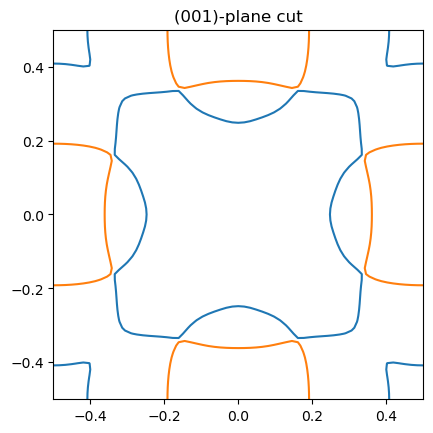

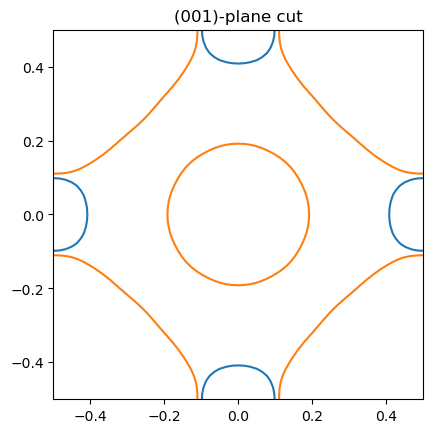

In [31]:
importlib.reload(fs)
fermi_energy = 16.157
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

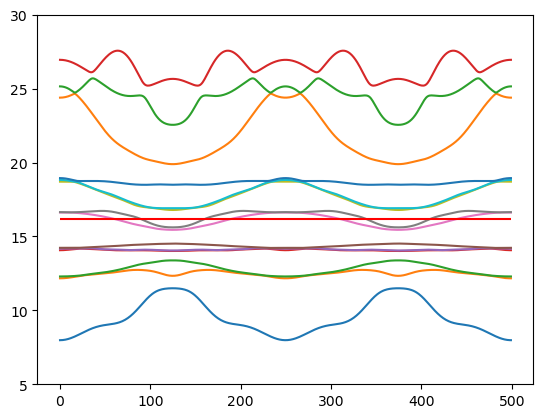

In [32]:
fermi_energy = 16.157
k_line = np.linspace(0, 2, 500).reshape(-1, 1) * [[1, 0, 0]]
tb_nitinol.plot_bands(k_line)
plt.hlines(fermi_energy, 0, len(k_line)-1, 'r')
plt.ylim(5, 30)
plt.show()

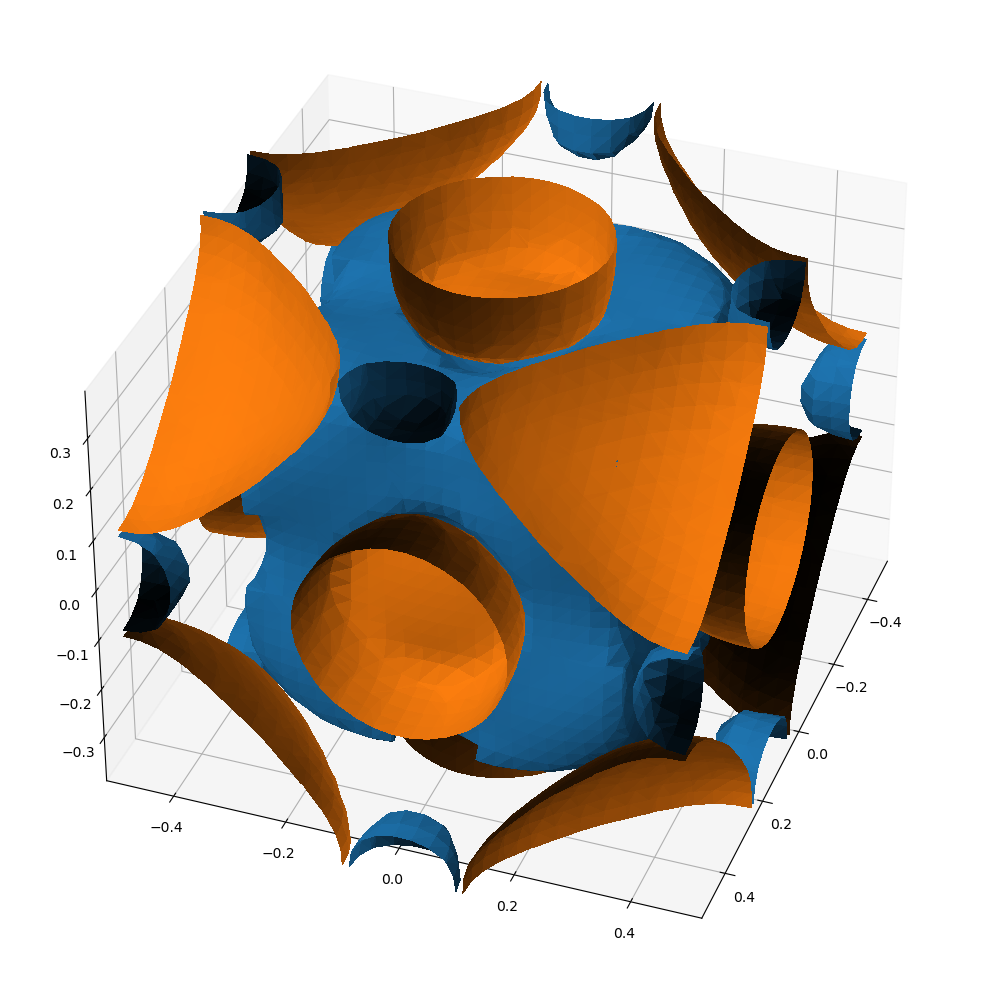

In [33]:
importlib.reload(fs)
# plot the fermi surface
fermi_energy = 16.157
fs.plot_3D_fermi_surface(tb_nitinol, fermi_energy, N=32)

In [14]:
# calculate conductivity (Czycholl page 269)
tau = 1e-15 # in s
elementary_charge = 1.602176634e-19 # in Coulomb
eV = elementary_charge # 1 eV in Joule
fermi_energy = 16.157 # in eV
T = 300
kB = 8.61733326214518e-5 # in eV/K
beta = 1 / (kB * T) # in 1/eV
alat = 2.993e-10 # m
hbar = 1.05457181764616e-34 # in SI J*s
k_unit = np.pi/2/alat # 1/m
def fermi(x):
    #return 1 / (1 + np.exp(x))
    return (np.tanh(-0.5 * x) + 1) * 0.5
def dfermi(x): # ~ exp(-x*x/5)/4
    #e = np.exp(x)
    #return -1 / (e + 2 + 1/e)
    return -0.25 / np.cosh(0.5 * x)**2
N = 20
k_smpl = np.meshgrid(np.linspace(0, 1, N, endpoint=False), np.linspace(0, 1, N, endpoint=False), np.linspace(0, 1, N, endpoint=False))
k_smpl += np.random.random(np.shape(k_smpl)) * ((1 - 0) / N) # this improves the integral a lot because it breaks symmetry -> *len(sym_group) integration sites
k_smpl = np.stack(k_smpl, axis=-1).reshape(-1, 3)
bands, grads = tb_nitinol.bands_grad(k_smpl)
v = grads * (eV / k_unit / hbar) # in m/s
#print(np.mean(np.mean(np.abs(v), axis=0), axis=1))
#print(np.mean(v)/np.mean(np.abs(v))) # this should be 0 for perfect sampling
# simplest integral formula
data = np.einsum("iaj,ibj,ij->iab", v, v, -dfermi((bands - fermi_energy) * beta))
I = np.mean(data, axis=0) # result is m^2/s^2
err = np.std(data, axis=0) / len(data)**0.5
sigma = 2 * elementary_charge**2 * tau * (beta*I)/eV / alat**3 # result is in 1/(Ohm*m)
avg_sigma = np.trace(sigma)/3
print(f"{sigma/avg_sigma}*{avg_sigma:.3e}\nwith error\n{err/np.abs(I)*100}%")

[[ 1.002 -0.008 -0.014]
 [-0.008  0.99  -0.005]
 [-0.014 -0.005  1.008]]*1.152e+07
with error
[[  4.08  233.061 134.736]
 [233.061   4.171 350.655]
 [134.736 350.655   4.028]]%


/tmp/ipykernel_136824/2492184768.py:18: RuntimeWarning: overflow encountered in cosh
  return -0.25 / np.cosh(0.5 * x)**2
/tmp/ipykernel_136824/2492184768.py:18: RuntimeWarning: overflow encountered in square
  return -0.25 / np.cosh(0.5 * x)**2


In [15]:
sigma_ref = 1 / 8.2e-8 # 1/(Ohm*m) Austenit (sc)
print(f"{sigma_ref:.2e}")
sigma_ref = 1 / 7.6e-8 # 1/(Ohm*m) Martensite
print(f"{sigma_ref:.2e}")

1.22e+07
1.32e+07
